In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# For the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from sklearn.svm import SVC

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


2024-09-28 23:35:49.246292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 23:35:49.334880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 23:35:49.638835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 23:35:49.694550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 23:35:49.799085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Load and Preprocess

In [6]:
import pandas as pd
import numpy as np
# Load datasets
anomaly_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/anomaliousTraffic.csv")
normal_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/normalTraffic.csv")
web_traffic_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/web_traffic.csv")


# Combine datasets
web_df = pd.concat([anomaly_df, normal_df, web_traffic_df], ignore_index=True)

# Handle missing values
web_df.fillna(0, inplace=True)

# Convert contentLength to numeric
web_df['contentLength'] = pd.to_numeric(web_df['contentLength'], errors='coerce')
web_df.fillna(0, inplace=True)  # Fill NaNs after conversion

# Define features and target
features = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 
            'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 
            'contentLength', 'payload']
target = 'label'

# Convert target variable to numeric
label_encoder = LabelEncoder()
web_df[target] = label_encoder.fit_transform(web_df[target])

# Split the dataset into features (X) and target (y)
X = web_df[features]
y = web_df[target]

# Encode categorical variables
categorical_cols = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 
                    'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 
                    'host', 'connection', 'payload']

# Label encode categorical features
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Scale the numerical data
scaler = StandardScaler()
X['contentLength'] = scaler.fit_transform(X[['contentLength']])

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



/tmp/ipykernel_44950/782773323.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  anomaly_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/anomaliousTraffic.csv")
/tmp/ipykernel_44950/782773323.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  normal_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/normalTraffic.csv")
/tmp/ipykernel_44950/782773323.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  web_traffic_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/web_traffic.csv")
/tmp/ipykernel_44950/782773323.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


# Combine datasets
web_df = pd.concat([anomaly_df, normal_df, web_traffic_df], ignore_index=True)

# Handle missing values
web_df.fillna(0, inplace=True)

# Convert contentLength to numeric (cleaning step)
web_df['contentLength'] = pd.to_numeric(web_df['contentLength'], errors='coerce')
web_df.fillna(0, inplace=True)

# Define features and target
features = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 
            'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 
            'contentLength', 'payload']
target = 'label'

# Convert target variable to numeric
label_encoder = LabelEncoder()
web_df[target] = label_encoder.fit_transform(web_df[target])

# Categorical columns
categorical_cols = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 
                    'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 
                    'host', 'connection', 'payload']

# Convert mixed-type columns to strings to ensure uniform data types
for col in categorical_cols:
    web_df[col] = web_df[col].astype(str)  # Convert to string type

# Label encode categorical features
for col in categorical_cols:
    web_df[col] = label_encoder.fit_transform(web_df[col])

# Scale the numerical data
scaler = StandardScaler()
web_df['contentLength'] = scaler.fit_transform(web_df[['contentLength']])

# Train-test split (80:20)
X = web_df[features]
y = web_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Reshape Data for CNN and LSTM

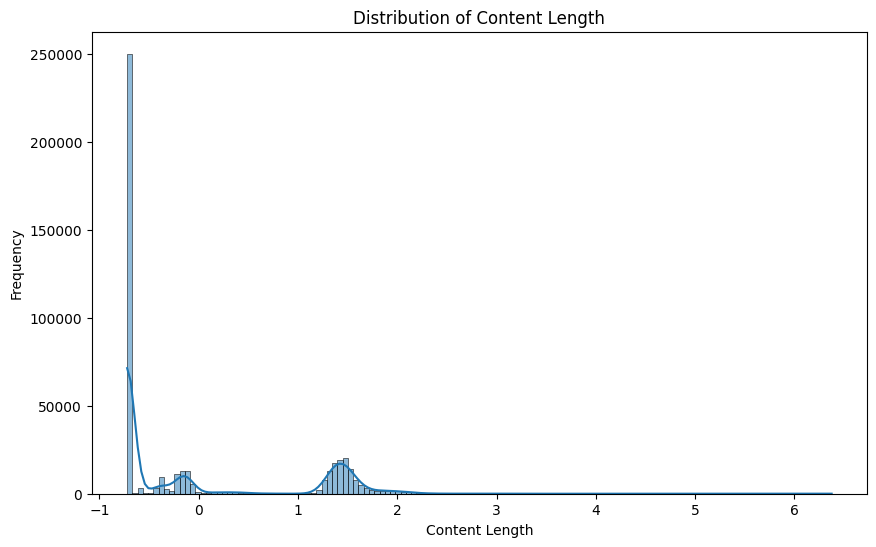

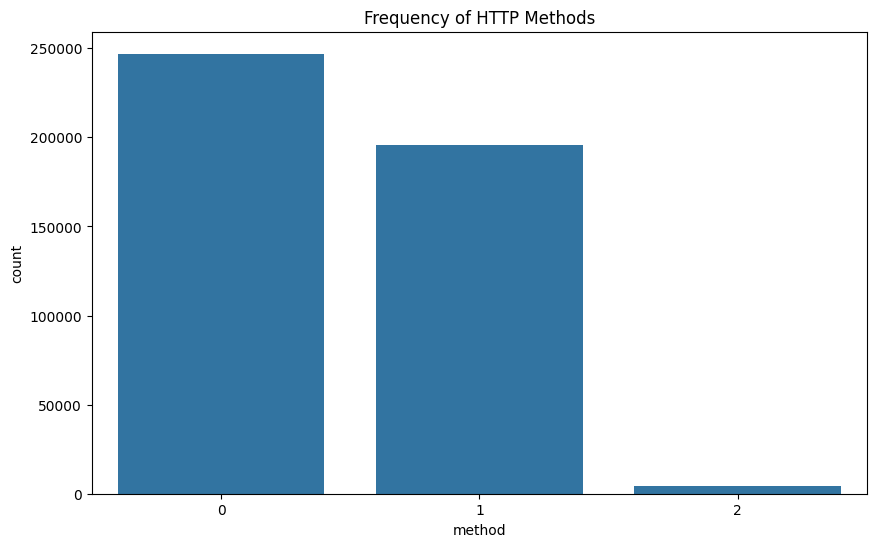

In [8]:
# EDA - Visualizing the Distribution of Content Length
plt.figure(figsize=(10, 6))
sns.histplot(web_df['contentLength'], kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

# EDA - Visualizing HTTP Methods
plt.figure(figsize=(10, 6))
sns.countplot(x='method', data=web_df)
plt.title('Frequency of HTTP Methods')
plt.show()


In [9]:
# Reshape data to 3D for CNN and LSTM
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)


# CNN for Feature Extraction

In [11]:

cnn_model = Sequential()

# Add Conv1D layer
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

# Output layer: one neuron with sigmoid activation for binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model (binary_crossentropy for binary classification)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract CNN features for both training and test sets
X_train_cnn_features = cnn_model.predict(X_train_reshaped)
X_test_cnn_features = cnn_model.predict(X_test_reshaped)



Epoch 1/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5226 - loss: 6.2575 - val_accuracy: 0.5602 - val_loss: 0.7483
Epoch 2/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5381 - loss: 1.5741 - val_accuracy: 0.4754 - val_loss: 0.9186
Epoch 3/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5388 - loss: 1.5697 - val_accuracy: 0.4745 - val_loss: 1.9461
Epoch 4/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5450 - loss: 1.2723 - val_accuracy: 0.5917 - val_loss: 1.1806
Epoch 5/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5467 - loss: 1.1823 - val_accuracy: 0.6019 - val_loss: 1.0275
Epoch 6/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5519 - loss: 1.1049 - val_accuracy: 0.6007 - val_loss: 1.1730
Epoch 7/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5548 - loss: 1.0571 - val_accuracy: 0.4963 - val_loss: 1.6661
Epoch 8/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5551 - loss: 1

# LSTM for Temporal Dependencies

In [13]:

lstm_model = Sequential()

# Add LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_cnn_features.shape[1], 1)))
lstm_model.add(LSTM(units=50))

# Add a final Dense layer with a single neuron and sigmoid activation for binary classification
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model for binary classification
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape CNN features for LSTM
X_train_lstm_input = np.expand_dims(X_train_cnn_features, axis=2)
X_test_lstm_input = np.expand_dims(X_test_cnn_features, axis=2)

# Train the LSTM model
lstm_model.fit(X_train_lstm_input, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract LSTM features
X_train_lstm_features = lstm_model.predict(X_train_lstm_input)
X_test_lstm_features = lstm_model.predict(X_test_lstm_input)



Epoch 1/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.5945 - loss: 0.6558 - val_accuracy: 0.5995 - val_loss: 0.6480
Epoch 2/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5903 - loss: 0.6482 - val_accuracy: 0.6011 - val_loss: 0.6378
Epoch 3/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5995 - loss: 0.6374 - val_accuracy: 0.6107 - val_loss: 0.6292
Epoch 4/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6083 - loss: 0.6282 - val_accuracy: 0.6124 - val_loss: 0.6224
Epoch 5/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6105 - loss: 0.6251 - val_accuracy: 0.6115 - val_loss: 0.6236
Epoch 6/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6110 - loss: 0.6240 - val_accuracy: 0.6120 - val_loss: 0.6220
Epoch 7/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6091 - loss: 0.6247 - val_accuracy: 0.6124 - val_loss: 0.6221
Epoch 8/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6106 - loss: 0

# SVM for Final Classification

In [14]:
# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1, gamma=0.1)

# Train the SVM model on LSTM features
svm_model.fit(X_train_lstm_features, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_lstm_features)


# Model Evaluation

Accuracy: 60.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.98      0.73     47929
           1       0.87      0.18      0.30     41505

    accuracy                           0.61     89434
   macro avg       0.73      0.58      0.52     89434
weighted avg       0.72      0.61      0.53     89434

Confusion Matrix:
[[46806  1123]
 [33910  7595]]


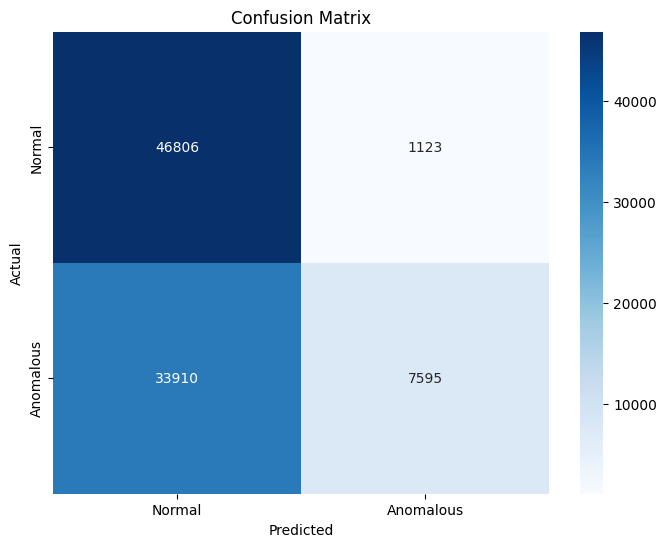

Precision: 0.87
Recall: 0.18
F1-Score: 0.30


In [15]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


# Hyperparameter Tuning for SVM

In [16]:
# Hyperparameter tuning for SVM using GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train_lstm_features, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train with best parameters
best_svm_model = grid_search.best_estimator_

# Predict with the best model
y_pred_best_svm = best_svm_model.predict(X_test_lstm_features)

# Evaluate the best SVM model
print("Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_best_svm))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=19.0min
